In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190527

In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf

In [3]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190527
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0-dev20190527


In [4]:
import cs230_project_utilities as utils

In [5]:
# GPU usage logging (TF 2.0+)
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

In [6]:
# Utility functions for creating TFRecord datasets
def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def bytes_list_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

# Convert raw data to TFRecords

In [7]:
def tf_example_for_slice_in_sequence(index, path, fft, image, cls):
    
    assert (image.shape[0] == image.shape[1] == fft.shape[0] == fft.shape[1] and
            image.shape[0] == 256 and fft.shape[-1] == 2), 'Image and fft shapes must be 256 x 256'
    
    # Create list of bytes with .tostring() for multidimensional ndarrays.
    example = tf.train.Example(features=tf.train.Features(feature={
        'path': bytes_feature(path.encode('utf-8')),
        'sequence_index': int64_feature(index),
        'fft': bytes_feature(fft.tostring()),
        'image': bytes_feature(image.tostring()),
        'dimension': int64_feature(image.shape[0]), # save dimension of fft and image to restore these keys
        'class': int64_feature(cls)
    }))
    
    return example

In [8]:
def tf_examples_for_h5_file_having_class(path, include_class):
    
    h5_data = utils.automap.read_h5_file(path)
    
    # Raw kspace data
    magnitude_sequence = h5_data['magnitude']
    phase_sequence = h5_data['phase']
    fft_sequence = np.concatenate((np.expand_dims(magnitude_sequence, axis=3),
                                   np.expand_dims(phase_sequence, axis=3)),
                                  axis=3)
    
    # Expected reconstruction images
    image_sequence = h5_data['images']
    image_sequence = np.expand_dims(image_sequence, axis=-1) # model expects 4 dims
    
    # Contains info on positive/negative samples
    class_sequence = h5_data['classification']

    examples = []
    for i in range(len(image_sequence)):
        example = tf_example_for_slice_in_sequence(i, path, fft_sequence[i],
                                                      image_sequence[i], class_sequence[i])
        
        if int(class_sequence[i]) == include_class:
            examples.append(example)
        
    return examples

In [9]:
def convert_dataset_to_tfrecord_files_for_class(h5_paths, dataset_directory, tfrecord_directory, include_class):
    tfrecord_file_pattern = os.path.join(tfrecord_directory, 'class_{}'.format(include_class), 'shard-{}.tfrecord')
    tfrecord_index = 0
    max_examples_per_tfrecord_file = 512
    examples_in_current_tfrecord_file = 0

    os.makedirs(os.path.dirname(tfrecord_file_pattern), exist_ok=True)
    
    tfrecord_path = tfrecord_file_pattern.format(tfrecord_index)
    writer = tf.io.TFRecordWriter(tfrecord_path)
    
    for path in h5_paths:
        try:
            examples = tf_examples_for_h5_file_having_class(path, include_class=include_class)
            for example in examples:
                writer.write(example.SerializeToString())
                examples_in_current_tfrecord_file += 1
                
                if examples_in_current_tfrecord_file >= max_examples_per_tfrecord_file:
                    writer.close()
                    tfrecord_index += 1
                    tfrecord_path = tfrecord_file_pattern.format(tfrecord_index)
                    writer = tf.io.TFRecordWriter(tfrecord_path)
                    examples_in_current_tfrecord_file = 0
                
        except Exception as e:
            print('Error creating example: {}'.format(e))

## Run conversion

In [10]:
# Get data with:
# sudo aws s3 cp s3://cs230-automap/data/raw /home/ubuntu/cs230/data/raw --recursive

# Troubleshooting:
# PermissionError: [Errno 13] Permission denied: '/home/ubuntu/cs230/data/tfrecords'
# Run: sudo chown -R $USER /home/ubuntu/cs230

In [11]:
raw_dataset_directory = '/home/ubuntu/cs230/data/raw'
tfrecord_directory = '/home/ubuntu/cs230/data/tfrecords'

test_directory = os.path.join(tfrecord_directory, 'test')
dev_directory = os.path.join(tfrecord_directory, 'dev')
train_directory = os.path.join(tfrecord_directory, 'train')

!ls -haltR $test_directory/ $dev_directory/ $train_directory/

/home/ubuntu/cs230/data/tfrecords/train/:
total 16K
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 27 23:06 class_1
drwxrwxr-x 4 ubuntu ubuntu 4.0K May 27 23:06 .
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 27 23:06 class_0
drwxrwxr-x 5 ubuntu ubuntu 4.0K May 27 23:06 ..

/home/ubuntu/cs230/data/tfrecords/train/class_1:
total 505M
-rw-rw-r-- 1 ubuntu ubuntu 121M May 28 06:03 shard-1.tfrecord
-rw-rw-r-- 1 ubuntu ubuntu 385M May 28 06:03 shard-0.tfrecord
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 27 23:06 .
drwxrwxr-x 4 ubuntu ubuntu 4.0K May 27 23:06 ..

/home/ubuntu/cs230/data/tfrecords/train/class_0:
total 613M
-rw-rw-r-- 1 ubuntu ubuntu 229M May 28 06:03 shard-1.tfrecord
-rw-rw-r-- 1 ubuntu ubuntu 385M May 28 06:03 shard-0.tfrecord
drwxrwxr-x 4 ubuntu ubuntu 4.0K May 27 23:06 ..
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 27 23:06 .

/home/ubuntu/cs230/data/tfrecords/dev/:
total 16K
drwxrwxr-x 5 ubuntu ubuntu 4.0K May 27 23:06 ..
drwxrwxr-x 4 ubuntu ubuntu 4.0K May 27 23:06 .
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 27 23

In [12]:
# Prepare test, dev, train splits
np.random.seed(0) # for reproducibility
h5_files = utils.automap.find_dataset_files(raw_dataset_directory)
h5_paths = [h5_files[key]['h5'] for key in np.random.permutation(list(h5_files.keys()))]

fraction_test, fraction_dev = 0.1, 0.1
num_paths = len(h5_paths)
num_test = int(num_paths * fraction_test) + 1
num_dev = int(num_paths * fraction_dev) + 1
test_paths = h5_paths[:num_test]
dev_paths = h5_paths[num_test:num_test + num_dev]
train_paths = h5_paths[num_test + num_dev:]

Found 134 .h5 files and 134 .txt files.


In [13]:
# Uncomment to create TFRecords (run if they don't already exist)
# convert_dataset_to_tfrecord_files_for_class(test_paths, raw_dataset_directory, test_directory, include_class=0)
# convert_dataset_to_tfrecord_files_for_class(test_paths, raw_dataset_directory, test_directory, include_class=1)

# convert_dataset_to_tfrecord_files_for_class(dev_paths, raw_dataset_directory, dev_directory, include_class=0)
# convert_dataset_to_tfrecord_files_for_class(dev_paths, raw_dataset_directory, dev_directory, include_class=1)

# convert_dataset_to_tfrecord_files_for_class(train_paths, raw_dataset_directory, train_directory, include_class=0)
# convert_dataset_to_tfrecord_files_for_class(train_paths, raw_dataset_directory, train_directory, include_class=1)

# Read converted dataset

In [14]:
def load_dataset(data_locations, batch_size, include_all_parsed_features):
    '''
    Returns iterator of automap data located in `data_locations`.
    
    data_locations:  A string, a list of strings, or a `tf.Tensor` of string type
    (scalar or vector), representing the filename glob (i.e. shell wildcard)
    pattern(s) that will be matched.
    '''
    filenames = tf.data.TFRecordDataset.list_files(data_locations)
    dataset = tf.data.TFRecordDataset(filenames)

    # Use `tf.parse_single_example()` to extract data from a `tf.Example`
    # protocol buffer, and perform any additional per-example processing.
    def parser(record):
        keys_to_features = {
            "path": tf.io.FixedLenFeature((), tf.string, ""),
            "sequence_index": tf.io.FixedLenFeature((), tf.int64, -1),
            "fft": tf.io.FixedLenFeature((), tf.string, ''),
            "image": tf.io.FixedLenFeature((), tf.string, ''),
            "dimension": tf.io.FixedLenFeature((), tf.int64, -1),
            "class": tf.io.FixedLenFeature((), tf.int64, -1)
        }
        parsed = tf.io.parse_single_example(record, keys_to_features)
        
        # Perform additional preprocessing on the parsed data.
        parsed['fft'] = tf.io.decode_raw(parsed['fft'], out_type=tf.float32)
        parsed['image'] = tf.io.decode_raw(parsed['image'], out_type=tf.float32)
        
        parsed['fft'] = tf.reshape(parsed['fft'], [parsed['dimension'], parsed['dimension'], 2])
        parsed['image'] = tf.reshape(parsed['image'], [parsed['dimension'], parsed['dimension'], 1])
        
        if include_all_parsed_features:
            return parsed
        
        # We only want input and expected output during training stage (X, Y)
        return parsed['fft'], parsed['image']



    # Use `Dataset.map()` to build a pair of a feature dictionary and a label
    # tensor for each example.
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.batch(batch_size)

    # Each element of `dataset` is tuple containing a dictionary of features
    # (in which each value is a batch of values for that feature), and a batch of
    # labels.
    return dataset

In [15]:
# Fetch a sample

In [16]:
test_data_locations = ['/home/ubuntu/cs230/data/tfrecords/test/class_1/*.tfrecord']
test_dataset = load_dataset(test_data_locations, batch_size=8, include_all_parsed_features=True)

In [17]:
sample = next(iter(test_dataset))

## Inspect a few samples in converted dataset

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 12) # increase size of subplots
plt.rcParams['image.cmap'] = 'gray' # b/w images

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


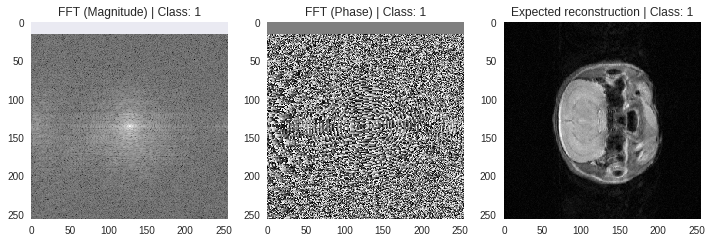

In [19]:
for key, value in sample.items():
    sample[key] = value.numpy()

fft_mag = sample['fft'][0, ..., 0]
fft_ang = sample['fft'][0, ..., 1]

cls = int(sample['class'][0])

plt.subplot(1, 3, 1)
plt.title('FFT (Magnitude) | Class: {}'.format(cls))
utils.plot.imshowfft(fft_mag)

plt.subplot(1, 3, 2)
plt.title('FFT (Phase) | Class: {}'.format(cls))
utils.plot.imshowgray(fft_ang)

plt.subplot(1, 3, 3)
plt.title('Expected reconstruction | Class: {}'.format(cls))
image = sample['image'][0, ..., 0]
utils.plot.imshowgray(image)

# Model

In [20]:
# We'll use this metric during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [21]:
def load_uncompiled_automap_model():
    N = 256
    small_N = N // 4 # after downsampling by 2 twice
    
    X = tf.keras.layers.Input(shape=(N, N, 2))
    noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-6)(X)
    conv_downsample1 = tf.keras.layers.Conv2D(16, (4, 4), strides=(2, 2), activation='tanh', padding='same')(noisy_X)
#     conv_downsample2 = tf.keras.layers.Conv2D(4, (4, 4), strides=(1, 1), activation='tanh', padding='same')(conv_downsample1)
    conv_downsample3 = tf.keras.layers.Conv2D(2, (4, 4), strides=(2, 2), activation='tanh', padding='same')(conv_downsample1)
    X1 = tf.keras.layers.Flatten()(conv_downsample3)
    
    # Workaround for: ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.
    X1 = tf.keras.layers.Reshape(target_shape=((small_N ** 2) * 2,))(X1)
    
    fc1 = tf.keras.layers.Dense((small_N ** 2) * 1, activation = 'tanh')(X1)
    fc1_DO = tf.keras.layers.Dropout(0.1)(fc1)
    
    fc2 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc1_DO)
    fc2_DO = tf.keras.layers.Dropout(0.1)(fc2)

    fc3 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc2_DO)
    X2 = tf.keras.layers.Reshape((small_N, small_N, 1))(fc3)
    conv1_1 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(X2)
    conv1_2 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(conv1_1)
    conv1_3a = tf.keras.layers.Conv2DTranspose(small_N, 9, activation='relu', padding='same')(conv1_2)
    conv1_3b = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3a)
    conv1_3c = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3b)
    
    Y_pred = tf.keras.layers.Conv2D(1, 1, activation = 'linear', padding='same')(conv1_3c)
    
    model = tf.keras.Model(inputs=X, outputs=Y_pred)
    
    return model

def load_compiled_automap_model(model):
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[mean_PSNR])
    return model

In [22]:
# def load_uncompiled_automap_model():
#     N = 256
#     small_N = N // 4 # after downsampling by 2 twice
    
#     X = tf.keras.layers.Input(shape=(N, N, 2))
#     noisy_X = tf.keras.layers.GaussianNoise(stddev=0.001)(X)
#     conv_downsample1 = tf.keras.layers.Conv2D(3, (4, 4), strides=(2, 2), activation='tanh', padding='same')(noisy_X)
#     conv_downsample2 = tf.keras.layers.Conv2D(3, (4, 4), strides=(1, 1), activation='tanh', padding='same')(conv_downsample1)
#     conv_downsample3 = tf.keras.layers.Conv2D(3, (4, 4), strides=(2, 2), activation='tanh', padding='same')(conv_downsample2)
#     X1 = tf.keras.layers.Flatten()(conv_downsample3)
    
#     # Workaround for: ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.
#     X1_reshaped = tf.keras.layers.Reshape(target_shape=((small_N ** 2) * 2,))(X1)
#     X1_DO = tf.keras.layers.Dropout(0.25)(X1_reshaped)
    
#     fc1 = tf.keras.layers.Dense((small_N ** 2) * 1, activation = 'tanh')(X1_DO)
#     fc1_DO = tf.keras.layers.Dropout(0.2)(fc1)
    
#     fc2 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc1_DO)
#     fc2_DO = tf.keras.layers.Dropout(0.2)(fc2)
#     fc3 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc2_DO)

# #     fc3 = tf.keras.layers.Dense(small_N ** 2, activation = 'tanh')(fc1_DO)
#     X2 = tf.keras.layers.Reshape((small_N, small_N, 1))(fc3)
    
#     conv1_1 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(X2)
#     conv1_2 = tf.keras.layers.Conv2D(small_N, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.0001))(conv1_1)
#     conv1_3a = tf.keras.layers.Conv2DTranspose(small_N, 9, activation='relu', padding='same')(conv1_2)
#     conv1_3b = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3a)
#     conv1_3c = tf.keras.layers.Conv2DTranspose(small_N, 9, strides=2, activation='relu', padding='same')(conv1_3b)
    
#     Y_pred = tf.keras.layers.Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3c)
    
#     model = tf.keras.Model(inputs=X, outputs=Y_pred)
    
#     return model

# def load_compiled_automap_model(model):
#     model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[mean_PSNR])
#     return model

In [23]:
tf.keras.backend.clear_session()

In [24]:
# Define where logs will be saved
logdir = "logs/scalars/" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")

In [25]:
# Custom learning rate schedule

def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    learning_rate = 1e-4
    if epoch > 40:
        learning_rate = 5e-5
    elif epoch > 80:
        learning_rate = 1e-5
    elif epoch > 100:
        learning_rate = 5e-6
    elif epoch > 150:
        learning_rate = 1e-6
    elif epoch > 180:
        learning_rate = 1e-7

    with file_writer.as_default():
        tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
        
    return learning_rate

# Show reconstructions during training

def plot_MRI_reconstructions(epoch, logs):
    
    batch = next(iter(test_dataset_all_features)) # always gets the first batch
    x = batch['fft'].numpy()
    y = batch['image'].numpy()
    y_pred = model.predict(x)
    
    y = np.reshape(y, (-1, 256, 256, 1))
    y_pred = np.reshape(y_pred, (-1, 256, 256, 1))
    
    with file_writer.as_default():
        for i in range(min(len(y), 8)):
            prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
            tf.summary.image("Test Image {} (Prediction)".format(i), prediction, max_outputs=1, step=epoch)
            tf.summary.image("Test Image {} (Ground Truth)".format(i), ground_truth, max_outputs=1, step=epoch)

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_MRI_reconstructions)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [26]:
# Send logs to Tensorboard (in a browser, navigate to: PUBLIC_DNS:6006)

# To view tensorboard output, make sure you've run:
# tensorboard --logdir logs/scalars

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# Troubleshoot:
# Make sure you have the correct env activated (on EC2 DL AMI): source activate tensorflow_p36
# Latest TB version: pip install -U tb-nightly
# Edit this instance's security group: add to "Inbound" a Custom TCP for port 6006, 0.0.0.0/0.
# Sometimes you have to run tensorboard --logdir logs/scalars OR tensorboard --logdir logs/scalars/<dir>
# a few times (after training has begun), otherwise TB doesn't see the logs.

In [27]:
model = load_compiled_automap_model(load_uncompiled_automap_model())
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 2)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      528       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 2)         514       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              335585

# Training

In [28]:
test_data_locations = ['/home/ubuntu/cs230/data/tfrecords/test/*/*.tfrecord']
dev_data_locations = ['/home/ubuntu/cs230/data/tfrecords/dev/*/*.tfrecord']
train_data_locations = ['/home/ubuntu/cs230/data/tfrecords/train/*/*.tfrecord']

batch_size = 16

test_dataset = load_dataset(test_data_locations, batch_size=batch_size, include_all_parsed_features=False)
dev_dataset = load_dataset(dev_data_locations, batch_size=batch_size, include_all_parsed_features=False)
train_dataset = load_dataset(train_data_locations, batch_size=batch_size, include_all_parsed_features=False)

test_dataset_all_features = load_dataset(test_data_locations, batch_size=batch_size, include_all_parsed_features=True)
dev_dataset_all_features = load_dataset(dev_data_locations, batch_size=batch_size, include_all_parsed_features=True)

In [29]:
# # Uncomment to load saved model and resume training
# saved_model_path = 'path_to_saved_model'
# model = tf.keras.models.load_model(saved_model_path)

In [30]:
training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=200,
    callbacks=[tensorboard_callback, lr_callback, plot_images_callback])

Epoch 1/200
94/94 [==============================] - 88s 938ms/step - loss: 0.2053 - mean_PSNR: 18.2257 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/200
94/94 [==============================] - 79s 842ms/step - loss: 0.1274 - mean_PSNR: 21.0187 - val_loss: 0.0995 - val_mean_PSNR: 20.5533
Epoch 3/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0733 - mean_PSNR: 21.8229 - val_loss: 0.0585 - val_mean_PSNR: 19.8922
Epoch 4/200
94/94 [==============================] - 79s 842ms/step - loss: 0.0395 - mean_PSNR: 21.6395 - val_loss: 0.0329 - val_mean_PSNR: 19.4250
Epoch 5/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0214 - mean_PSNR: 21.8505 - val_loss: 0.0199 - val_mean_PSNR: 20.4463
Epoch 6/200
94/94 [==============================] - 79s 842ms/step - loss: 0.0145 - mean_PSNR: 22.3201 - val_loss: 0.0168 - val_mean_PSNR: 20.3669
Epoch 7/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0121 - mean_PSNR: 22.4311 -

Epoch 56/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0041 - mean_PSNR: 24.7521 - val_loss: 0.0106 - val_mean_PSNR: 20.5654
Epoch 57/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0035 - mean_PSNR: 25.3183 - val_loss: 0.0107 - val_mean_PSNR: 20.5423
Epoch 58/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0034 - mean_PSNR: 25.5973 - val_loss: 0.0114 - val_mean_PSNR: 20.3754
Epoch 59/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0033 - mean_PSNR: 25.6858 - val_loss: 0.0119 - val_mean_PSNR: 20.1765
Epoch 60/200
94/94 [==============================] - 79s 842ms/step - loss: 0.0033 - mean_PSNR: 25.6782 - val_loss: 0.0114 - val_mean_PSNR: 20.3234
Epoch 61/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0032 - mean_PSNR: 25.7803 - val_loss: 0.0107 - val_mean_PSNR: 20.5863
Epoch 62/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0031 - mean_PSNR: 25.9300 -

Epoch 111/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0027 - mean_PSNR: 26.3256 - val_loss: 0.0122 - val_mean_PSNR: 20.2632
Epoch 112/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0027 - mean_PSNR: 26.3589 - val_loss: 0.0111 - val_mean_PSNR: 20.5599
Epoch 113/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0026 - mean_PSNR: 26.5116 - val_loss: 0.0115 - val_mean_PSNR: 20.4931
Epoch 114/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0026 - mean_PSNR: 26.5894 - val_loss: 0.0123 - val_mean_PSNR: 20.3288
Epoch 115/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0025 - mean_PSNR: 26.7338 - val_loss: 0.0127 - val_mean_PSNR: 20.2282
Epoch 116/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0025 - mean_PSNR: 26.7729 - val_loss: 0.0125 - val_mean_PSNR: 20.2857
Epoch 117/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0025 - mean_PSNR: 26

94/94 [==============================] - 79s 841ms/step - loss: 0.0022 - mean_PSNR: 27.3478 - val_loss: 0.0125 - val_mean_PSNR: 20.3660
Epoch 166/200
94/94 [==============================] - 79s 841ms/step - loss: 0.0022 - mean_PSNR: 27.3582 - val_loss: 0.0125 - val_mean_PSNR: 20.3681
Epoch 167/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0022 - mean_PSNR: 27.3732 - val_loss: 0.0126 - val_mean_PSNR: 20.3495
Epoch 168/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0022 - mean_PSNR: 27.3811 - val_loss: 0.0127 - val_mean_PSNR: 20.3389
Epoch 169/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0022 - mean_PSNR: 27.3917 - val_loss: 0.0127 - val_mean_PSNR: 20.3389
Epoch 170/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0022 - mean_PSNR: 27.3989 - val_loss: 0.0128 - val_mean_PSNR: 20.3155
Epoch 171/200
94/94 [==============================] - 79s 840ms/step - loss: 0.0022 - mean_PSNR: 27.4086 - val_lo

In [31]:
# # Uncomment to save model
saved_model_path = 'automap_mixed_class_200_epochs'
model.save(saved_model_path)

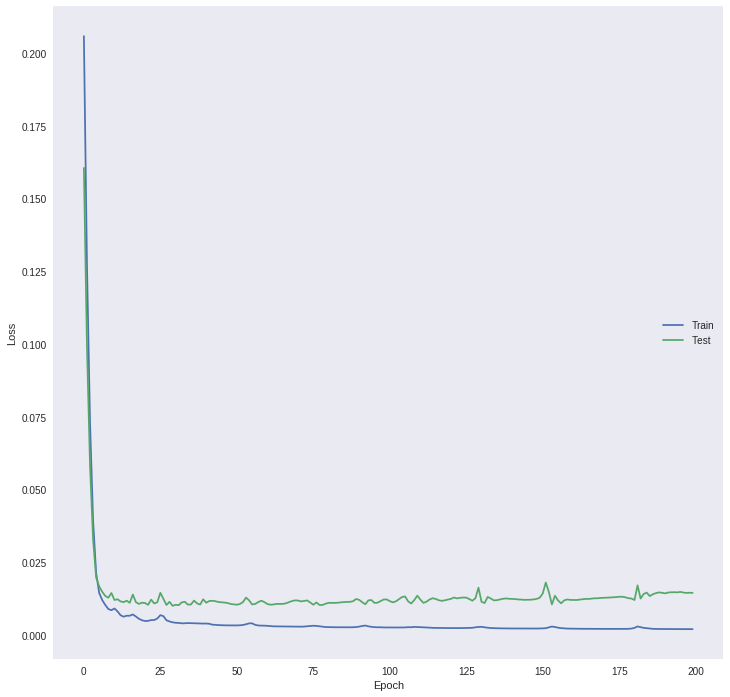

In [32]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

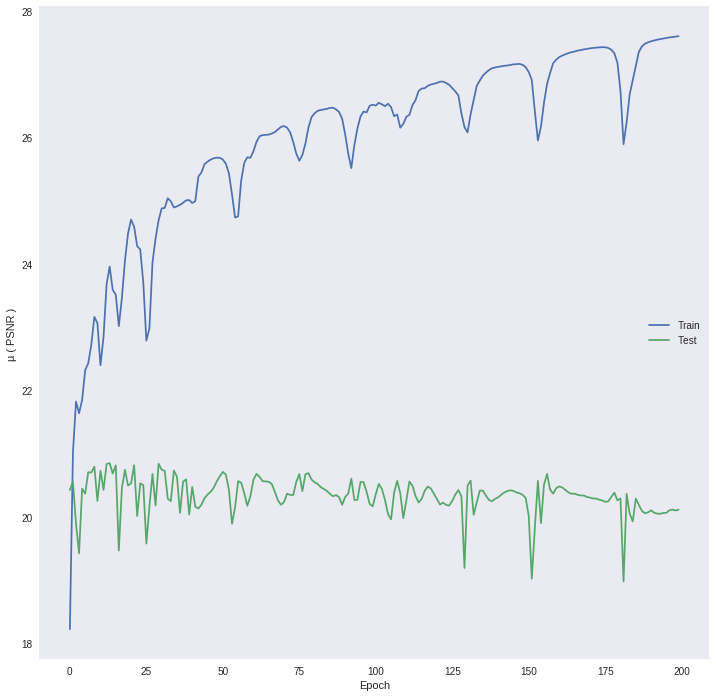

In [33]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

In [34]:
model.evaluate(test_dataset)

     12/Unknown - 3s 287ms/step - loss: 0.0114 - mean_PSNR: 20.7708

[0.011366019840352237, 20.770794]

In [35]:
model.evaluate(dev_dataset)

     13/Unknown - 3s 217ms/step - loss: 0.0145 - mean_PSNR: 20.1159

[0.014530819840729237, 20.115883]

In [36]:
model.evaluate(train_dataset)

     94/Unknown - 21s 220ms/step - loss: 0.0021 - mean_PSNR: 27.5545

[0.0020962434962015363, 27.55453]

In [37]:
# Predict on a test batch

for batch in test_dataset_all_features:
    x = batch['fft'].numpy()
    y = batch['image'].numpy()
    cls = batch['class']
    y_pred = model.predict(x)
    break

Class: 1


/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


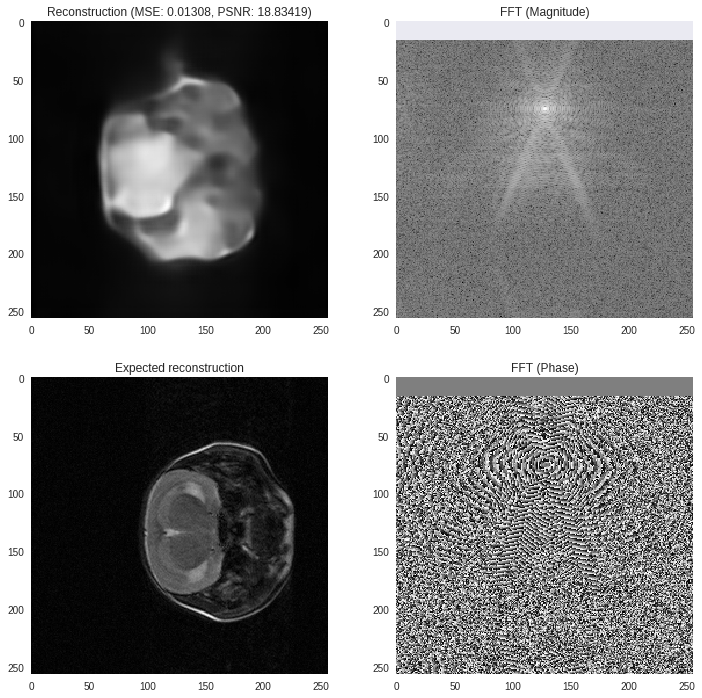

In [38]:
# Inspect output

for i in range(len(x)):
    
    fft_mag = x[i, ..., 0]
    fft_ang = x[i, ..., 1]
    c = int(cls[i])
    reconstruction = y_pred[i, ..., 0]
    reconstruction[reconstruction < 0] = 0
    reconstruction[reconstruction > 1] = 1
    image = y[i, ..., 0]

    print('Class: {}'.format(c))
    
    MSE = utils.signal_processing.mean_square_error(reconstruction, image)
    PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=1.0)

    plt.subplot(2, 2, 1)
    plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
    utils.plot.imshowgray(reconstruction)

    plt.subplot(2, 2, 2)
    plt.title('FFT (Magnitude)')
    utils.plot.imshowfft(fft_mag)

    plt.subplot(2, 2, 3)
    plt.title('Expected reconstruction')
    utils.plot.imshowgray(image)

    plt.subplot(2, 2, 4)
    plt.title('FFT (Phase)')
    utils.plot.imshowgray(fft_ang)

    plt.show()
    
    break

In [39]:
# # In theory, in TF 2.0 we should be able to see Tensorboard in this notebook with magics:
# %load_ext tensorboard
# %tensorboard --logdir logs

# Clear logs if needed
# !rm -rf logs/